# Data Loading & Pre-Processing

Dataset is located on github here: https://github.com/openai/gpt-2-output-dataset/blob/master/README.md

In [ ]:
import os
import sys
import requests
from tqdm import tqdm

subdir = 'data'
if not os.path.exists(subdir):
    os.makedirs(subdir)
subdir = subdir.replace('\\','/') # needed for Windows


# Just downloading outputs from strongest version (xl-1542M)

# The dataset contains train, valid and test sets, but the number of samples
# is so large that we only need the training set (250,000 samples)
filename = 'xl-1542M-k40.train.jsonl'
r = requests.get("https://openaipublic.azureedge.net/gpt-2/output-dataset/v1/" + filename, stream=True)

with open(os.path.join(subdir, filename), 'wb') as f:
    file_size = int(r.headers["content-length"])
    chunk_size = 1000
    with tqdm(ncols=100, desc="Fetching " + filename, total=file_size, unit_scale=True) as pbar:
        # 1k for chunk_size, since Ethernet packet size is around 1500 bytes
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            pbar.update(chunk_size)

Fetching xl-1542M-k40.train.jsonl: 748Mit [00:11, 67.1Mit/s]                                        


In [ ]:
import pandas as pd

In [ ]:
ai_df = pd.read_json('/content/data/xl-1542M-k40.train.jsonl', lines=True)

In [ ]:
# Confirm length is correct (250,000 expected)
print("Number of AI text articles: " + str(len(ai_df)))

Number of AI text articles: 250000


In [ ]:
ai_df.head()

,id,text,length,ended
0,1,"Cops will have to take ""extreme care"" to avoid...",433,True
1,2,The latest edition of the German Football Hall...,715,True
2,3,"Dangerous animals, especially snakes, in a car...",1024,False
3,4,I started my first MLP story way back in 2014 ...,1024,False
4,5,This article is a disambiguation page for The ...,84,True


In [ ]:
# Printing first output
ai_df.iloc[0, 1]

'Cops will have to take "extreme care" to avoid jail-breaking the latest iPhones as the US government will fine manufacturers for breaking its digital security.\n\nApple has been criticised for designing and releasing its latest smartphone without any security measures.\n\nApple has defended the iPhone 6 for carrying out some of its advanced security measures, but will be fined if it continues to fail that test.\n\nThe Federal Communications Commission and FBI will be allowed to fine companies as much as $25,000 (£17,800) for not patching bugs after they are announced.\n\nThe FCC, under a new ruling from president Obama , will allow fines of $1,500 per device over the same "bug bounty".\n\nThere have been multiple hacks into iPhone 6 smartphones this year in the wake of the 2013 revelation that the device could be unlocked with a passcode lock.\n\nHowever, security experts have criticised Apple\'s software and device for not patching its bugs to prevent them becoming the latest weapon 

In [ ]:
# Only keep articles where ended == True
ai_df = ai_df[ai_df['ended']==True]

print("# of AI samples after dropping incomplete text: " + str(len(ai_df)))

# of AI samples after dropping incomplete text: 175735


In [ ]:
# Now dropping the "ended" and "length" columns 
ai_df.drop(labels=['ended', 'length', 'id'], axis=1, inplace=True)

ai_df.head()

,text
0,"Cops will have to take ""extreme care"" to avoid..."
1,The latest edition of the German Football Hall...
4,This article is a disambiguation page for The ...
9,What is it?\n\nIt's a video game that's a comb...
10,Greetings Saviors!We hope you're all well and ...


## Download to Pre-Processing Human-Authored Real/Fake News

Manually uploaded files from: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset/download



In [ ]:
real_df = pd.read_csv('/content/True.csv')
fake_df = pd.read_csv('/content/Fake.csv')

In [ ]:
print("# Real articles: " + str(len(real_df)))

print("# Fake articles: " + str(len(fake_df)))

# Real articles: 21417
# Fake articles: 23481


In [ ]:
# Viewing dataframe
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
# Dropping title, subject and data columns since we cant use these in AI-text
real_df.drop(labels=['title', 'subject', 'date'], axis=1, inplace=True)
fake_df.drop(labels=['title', 'subject', 'date'], axis=1, inplace=True)

real_df.head()

,text
0,WASHINGTON (Reuters) - The head of a conservat...
1,WASHINGTON (Reuters) - Transgender people will...
2,WASHINGTON (Reuters) - The special counsel inv...
3,WASHINGTON (Reuters) - Trump campaign adviser ...
4,SEATTLE/WASHINGTON (Reuters) - President Donal...


In [ ]:
# Real articles that contain "Reuters" in them
real_df[real_df['text'].str.contains("Reuters")]

,text
0,WASHINGTON (Reuters) - The head of a conservat...
1,WASHINGTON (Reuters) - Transgender people will...
2,WASHINGTON (Reuters) - The special counsel inv...
3,WASHINGTON (Reuters) - Trump campaign adviser ...
4,SEATTLE/WASHINGTON (Reuters) - President Donal...
...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...
21413,"LONDON (Reuters) - LexisNexis, a provider of l..."
21414,MINSK (Reuters) - In the shadow of disused Sov...
21415,MOSCOW (Reuters) - Vatican Secretary of State ...


In [ ]:
# Fake articles that contain "Reuters" in them
fake_df[fake_df['text'].str.contains("Reuters")]

,text
115,Republicans should be downright afraid to try ...
265,"Before departing for Puerto Rico, Donald Trump..."
348,By now you would be more than aware of Preside...
350,Donald Trump has been fundraising like crazy f...
417,"After Hurricane Harvey devastated Houston, Tex..."
...,...
23275,Shawn Helton 21st Century WireAnother active-s...
23308,"Daily Shooter 21st Century WireLast night, a h..."
23344,21st Century Wire says The military industrial...
23359,21st Century Wire says A greater percentage of...


In [ ]:
# Remove 'Reuters) - ' and anything that comes before it
real_df['text'] = real_df['text'].apply(lambda x: x.split('Reuters) - ')[-1])

# Remove 'Reuters' even if it doesnt follow format above
real_df['text'] = real_df['text'].apply(lambda x: x.replace('Reuters', ''))


# Print remaining rows containing Reuters - expecting empty DataFrame
print(real_df[real_df['text'].str.contains("Reuters")])

Empty DataFrame
Columns: [text]
Index: []


In [ ]:
# Repeat for Fake df
fake_df['text'] = fake_df['text'].apply(lambda x: x.split('Reuters) - ')[-1])
fake_df['text'] = fake_df['text'].apply(lambda x: x.replace('Reuters', ''))

# Print remaining rows containing Reuters - expecting empty DataFrame
print(fake_df[fake_df['text'].str.contains("Reuters")])

Empty DataFrame
Columns: [text]
Index: []


In [ ]:
# Examples of text we want to clean

# Contains '\n' 
ai_df.text.iloc[0]

#Contains unicode space '\xa0'
real_df.text.iloc[13]

# Contains https link
fake_df.text.iloc[3]


'On Christmas day, Donald Trump announced that he would  be back to work  the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH  Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this administration is bizarre AF. The coding contained a reference to Obama and golf:  Unlike Obama, we are working to fix the problem   and not on the golf course.  However, the coding wasn t done correctly.The website of Donald Trump, who has spent several days in a row at the golf course, is coded to serve up the fo

In [ ]:
import re

def clean_text(text):
  """Cleans newline characters, unix whitespace, 
  and http links from text"""

  text = re.sub(r'\n', ' ', text)
  text = re.sub('\xa0', ' ', text)
  cleaned_text = re.sub('(http)(.+?)(?:\s)', ' ', text)   # 'http' followed by text up until space char

  return cleaned_text

In [ ]:
# Before cleaning
# Contains '\n' 
ai_df.text.iloc[0]

# #Contains unicode space '\xa0'
# real_df.text.iloc[13]

# # # Contains https link
# fake_df.text.iloc[3]

'Cops will have to take "extreme care" to avoid jail-breaking the latest iPhones as the US government will fine manufacturers for breaking its digital security.\n\nApple has been criticised for designing and releasing its latest smartphone without any security measures.\n\nApple has defended the iPhone 6 for carrying out some of its advanced security measures, but will be fined if it continues to fail that test.\n\nThe Federal Communications Commission and FBI will be allowed to fine companies as much as $25,000 (£17,800) for not patching bugs after they are announced.\n\nThe FCC, under a new ruling from president Obama , will allow fines of $1,500 per device over the same "bug bounty".\n\nThere have been multiple hacks into iPhone 6 smartphones this year in the wake of the 2013 revelation that the device could be unlocked with a passcode lock.\n\nHowever, security experts have criticised Apple\'s software and device for not patching its bugs to prevent them becoming the latest weapon 

In [ ]:
#After cleaning
clean_text(ai_df.text.iloc[0])

'Cops will have to take "extreme care" to avoid jail-breaking the latest iPhones as the US government will fine manufacturers for breaking its digital security.  Apple has been criticised for designing and releasing its latest smartphone without any security measures.  Apple has defended the iPhone 6 for carrying out some of its advanced security measures, but will be fined if it continues to fail that test.  The Federal Communications Commission and FBI will be allowed to fine companies as much as $25,000 (£17,800) for not patching bugs after they are announced.  The FCC, under a new ruling from president Obama , will allow fines of $1,500 per device over the same "bug bounty".  There have been multiple hacks into iPhone 6 smartphones this year in the wake of the 2013 revelation that the device could be unlocked with a passcode lock.  However, security experts have criticised Apple\'s software and device for not patching its bugs to prevent them becoming the latest weapon in the fight

In [ ]:
# Clean the text on all dfs

df_list = [real_df, fake_df, ai_df]

for df in df_list:
  df['text'] = df['text'].apply(lambda x: clean_text(x))

In [ ]:
real_df["group"] = "real"
fake_df["group"] = "fake_hum"
ai_df["group"] = "fake_ai"

In [ ]:
# Combining dfs
articles_df = real_df.append([fake_df, ai_df], verify_integrity=True, ignore_index=True)

articles_df

,text,group
0,The head of a conservative Republican faction ...,real
1,Transgender people will be allowed for the fir...,real
2,The special counsel investigation of links bet...,real
3,Trump campaign adviser George Papadopoulos tol...,real
4,President Donald Trump called on the U.S. Post...,real
...,...,...
220628,"""You are like a child and you do not know what...",fake_ai
220629,There are a lot of things that I don't like ab...,fake_ai
220630,Battles Between the English and the Scots The...,fake_ai
220631,Kurt Rambis is the new head coach of the Knick...,fake_ai


In [ ]:
# Are there duplicates?

articles_df[articles_df["group"] == 'fake_hum'] # of fake_hum articles: 21226 
len(articles_df[articles_df["group"] == 'fake_hum'].text.unique()) # 16385 unique fake_hum articles


articles_df[articles_df["group"] == 'real'] # of real articles: 20253 
len(articles_df[articles_df["group"] == 'real'].text.unique()) # 20043 unique real articles


articles_df[articles_df["group"] == 'fake_ai'] # of ai articles: 165190 
len(articles_df[articles_df["group"] == 'fake_ai'].text.unique()) # 165121 unique ai articles

# Yes, all 3 groups have some duplicates, particularly the fake_hum group with 4841 duplicate articles.
# fake_ai and real each have < 250 duplicates
# 5,120 duplicate articles total

16306

In [ ]:
# Dropping rows with duplicate articles
articles_df.drop_duplicates(subset=['text'], inplace=True, ignore_index=True)

articles_df


,text,group
0,The head of a conservative Republican faction ...,real
1,Transgender people will be allowed for the fir...,real
2,The special counsel investigation of links bet...,real
3,Trump campaign adviser George Papadopoulos tol...,real
4,President Donald Trump called on the U.S. Post...,real
...,...,...
214253,"""You are like a child and you do not know what...",fake_ai
214254,There are a lot of things that I don't like ab...,fake_ai
214255,Battles Between the English and the Scots The...,fake_ai
214256,Kurt Rambis is the new head coach of the Knick...,fake_ai


In [ ]:
# Longest fake_ai article
articles_df[articles_df.group == 'fake_ai'].length.max()

5711

In [ ]:
# All articles that are too long
articles_df[articles_df.length > 5711]

,text,group,length
20,The U.S. Justice Department has issued new gui...,real,5746
32,"In the Fox & Hound sports bar, next to a shopp...",real,6679
48,The Republican-controlled U.S. House of Repres...,real,5811
63,The two Democratic candidates running for gove...,real,8133
68,The U.S. House of Representatives gave final a...,real,7006
...,...,...,...
36420,Patrick Henningsen 21st Century WireRemember ...,fake_hum,25065
36423,21st Century Wire says All the world s a stage...,fake_hum,7359
36424,Randy Johnson 21st Century WireThe majority ...,fake_hum,26275
36426,21st Century Wire says A new front has just op...,fake_hum,20651


In [ ]:
# importing word_tokenize to use in function below
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def article_crop(article, char_limit):
  """Given a DataFrame row that contains a 'text' column and a character limit, this crops
      the text to end at the sentence after the character limit is reached

  Params
  - row: a row of a Dataframe that contains 'text' column
  - char_limit: int, once text reaches this limit, the current sentence will become the final sentence in the text
  """


  # If text is longer than char limit
  if len(article) > char_limit:

    # Split text into two groups, before and after the character limit
    before_limit = article[: char_limit]
    after_limit = article[char_limit : ]

    # If after_limit contains more than just whitespace (check is needed b/c calling sent_tokenize()[0] on whitespace will fail)
    if len(nltk.sent_tokenize(after_limit)) > 0:

      sent_after_limit = nltk.sent_tokenize(after_limit)[0] # Take 1st sentence after char_limit
      
      new_text = before_limit + sent_after_limit
      return new_text

    # In this case, chars after char_limit only contain whitespace
    else:
      return before_limit

  else:
    return article

In [ ]:
# Shows where data will be cut off at the limit
articles_df.text.iloc[63][5400:5711] 

' Dan Cantor, national chairman of the Working Families Party.      MoveOn, whose recent endorsement of Abrams marked its first in a 2018 governor’s race, said it would mobilize its 125,000 Georgia members as volunteers for her campaign.      Democracy for America is similarly engaging nearly 35,000 members in '

In [ ]:
# Shows the final sentence being completed using article_crop()
article_crop(articles_df.text.iloc[63], 5711)[5400:] 

' Dan Cantor, national chairman of the Working Families Party.      MoveOn, whose recent endorsement of Abrams marked its first in a 2018 governor’s race, said it would mobilize its 125,000 Georgia members as volunteers for her campaign.      Democracy for America is similarly engaging nearly 35,000 members in the state.'

In [ ]:
# For texts longer than 5711 chars (the longest AI text), crop when the sentence at 5711 chars ends
articles_df['text'] = articles_df.text.apply(lambda x: article_crop(x, 5711))
articles_df

,text,group,length
0,The head of a conservative Republican faction ...,real,4636
1,Transgender people will be allowed for the fir...,real,4054
2,The special counsel investigation of links bet...,real,2766
3,Trump campaign adviser George Papadopoulos tol...,real,2431
4,President Donald Trump called on the U.S. Post...,real,5173
...,...,...,...
201544,Rise: The Dawn of Justice: $3-4 per copy Rise...,fake_ai,2154
201545,There are a lot of things that I don't like ab...,fake_ai,3675
201546,Battles Between the English and the Scots The...,fake_ai,3650
201547,Kurt Rambis is the new head coach of the Knick...,fake_ai,1838


In [ ]:
# articles that are still really long
articles_df[articles_df.length > 8000]

,text,group,length
22681,"In another of Donald Trump s whine rests, the ...",fake_hum,9912
35379,Fundamental transformation Obama style Henry C...,fake_hum,11049


In [ ]:
# Last part of articles that are still really long
# Both are sentences separated by colons and semicolons
articles_df.text.iloc[22681][-2500:]
articles_df.text.iloc[35379][-2500:]

'g offense; Southern District of Alabama Sentence: 180 months  imprisonment; eight years  supervised release (March 8, 2007) Commutation Grant: Prison sentence commuted to expire on July 28, 2016, and supervised release term commuted to four years of supervised release.Isadore Gennings   Cincinnati, OH Offense: Conspiracy to distribute cocaine; interstate travel in aid of racketeering enterprises; possession with intent to distribute in excess of five kilograms of cocaine; Southern District of Ohio Sentence: 240 months  imprisonment; 10 years  supervised release (March 14, 2002) Commutation Grant: Prison sentence commuted to expire on July 28, 2016, and supervised release term commuted to five years of supervised release.Lamont Durville Glass   Knoxville, TN Offense: Possession with intent to distribute cocaine base; felon in possession of a firearm; Eastern District of Tennessee Sentence: 262 months  imprisonment; eight years  supervised release (January 9, 1998) Commutation Grant: Pr

In [ ]:
# Tokenize sentences
articles_df['sentences'] = articles_df['text'].apply(lambda x: nltk.sent_tokenize(x))

articles_df

,text,group,length,sentences
0,The head of a conservative Republican faction ...,real,4636,[The head of a conservative Republican faction...
1,Transgender people will be allowed for the fir...,real,4054,[Transgender people will be allowed for the fi...
2,The special counsel investigation of links bet...,real,2766,[The special counsel investigation of links be...
3,Trump campaign adviser George Papadopoulos tol...,real,2431,[Trump campaign adviser George Papadopoulos to...
4,President Donald Trump called on the U.S. Post...,real,5173,"[President Donald Trump called on the U.S., Po..."
...,...,...,...,...
201544,Rise: The Dawn of Justice: $3-4 per copy Rise...,fake_ai,2154,[Rise: The Dawn of Justice: $3-4 per copy Ris...
201545,There are a lot of things that I don't like ab...,fake_ai,3675,[There are a lot of things that I don't like a...
201546,Battles Between the English and the Scots The...,fake_ai,3650,[Battles Between the English and the Scots Th...
201547,Kurt Rambis is the new head coach of the Knick...,fake_ai,1838,[Kurt Rambis is the new head coach of the Knic...


In [ ]:
def avg_words_per_sent(text):
  """Feed a list of sentences (param:text) and 
  returns the average number of words per sentence"""
  
  num_words_list = [] # List of word count per sentence
  
  for sent in range(len(text)):

    # Number of words in a sentence, excludes punctuation
    num_words = len([word for word in word_tokenize(text[sent]) if word.isalnum()])
    
    # Add number of words for sentence to the list
    num_words_list.append(num_words)

  
  # Compute the average
  avg_word_per_sentences = sum(num_words_list) / len(num_words_list)

  return avg_word_per_sentences


In [ ]:
# Compute avg words per sentence for each column
articles_df['words_per_sent'] = articles_df['sentences'].apply(lambda x: avg_words_per_sent(x))

In [ ]:
articles_df.head()

,text,group,length,sentences,words_per_sent
0,The head of a conservative Republican faction ...,real,4636,[The head of a conservative Republican faction...,24.700000
1,Transgender people will be allowed for the fir...,real,4054,[Transgender people will be allowed for the fi...,29.190476
2,The special counsel investigation of links bet...,real,2766,[The special counsel investigation of links be...,26.882353
3,Trump campaign adviser George Papadopoulos tol...,real,2431,[Trump campaign adviser George Papadopoulos to...,23.312500
4,President Donald Trump called on the U.S. Post...,real,5173,"[President Donald Trump called on the U.S., Po...",20.850000


In [ ]:
# AI text higher than 100 words per sentence
articles_df[(articles_df['words_per_sent'] > 100) & (articles_df['group'] == "fake_ai")]

,text,group,length,sentences,words_per_sent
36773,"PURCHASE TICKETS Tuesday, May 3 – The Last Ki...",fake_ai,1780,"[PURCHASE TICKETS Tuesday, May 3 – The Last K...",303.000000
36986,Forum Jump User Control Panel Private Message...,fake_ai,946,[Forum Jump User Control Panel Private Messag...,122.000000
37289,The first season of HBO's Girls has been one l...,fake_ai,5048,[The first season of HBO's Girls has been one ...,274.666667
37398,On this episode we talk to writer/director and...,fake_ai,833,[On this episode we talk to writer/director an...,136.000000
37684,(1) A person commits criminal trespass in the ...,fake_ai,803,[(1) A person commits criminal trespass in the...,139.000000
...,...,...,...,...,...
199411,1 Clean Episode 20: The Biggest Deal In The Hi...,fake_ai,2796,[1 Clean Episode 20: The Biggest Deal In The H...,260.000000
199911,1st Round 1st Overall 1st Team 2nd Team 2nd Te...,fake_ai,1225,[1st Round 1st Overall 1st Team 2nd Team 2nd T...,178.000000
200086,1 of 11 View Caption Steve Griffin | BDN Stev...,fake_ai,785,[1 of 11 View Caption Steve Griffin | BDN Ste...,121.000000
200394,The following is a list of items that make goo...,fake_ai,5641,[The following is a list of items that make go...,166.400000


In [ ]:
# AI-generated lyric example
articles_df.text.iloc[43307]

"Lyrics  I've seen you stand  I've heard you call  It's been so hard, you've left me, goodbye  You made me smile  I saw you stand all night long  You looked as if you were going right to sleep  And I know you wouldn't lie to me   I know you wouldn't lie to me, tell me you didn't want to see me  You couldn't hide your smile when I was here  You had the courage of what you were gonna do  And I know you wouldn't lie to me, tell me you wouldn't  I've told you so many times  Laugh, cry, love, hurt  I've seen you stand with me  Laugh, cry, love, hurt  I've seen you stand, I've heard you call, let's go  You said 'we,' I said 'me'  It was in the middle of the night  We were standing on edge together, my heart is breaking  I saw it all before  You told me you loved me every time  And you said goodbye  And I know you wouldn't lie to me, tell me it wasn't true  You said you would wait by the phone  For you  I've told you so many times  Laugh, cry, love, hurt  I've seen you stand, I've heard you c

In [ ]:
# AI-generated youtube page example
articles_df.text.iloc[49514]

'Categories  Categories Select Category 90 Days (9) All Access Passes (3) Books (1) Briefing for Authors (2) Briefing for Authors and Publishers (10) Calendars (1) Conferences (1) Content and Tools for Authors (20) Editing Tools (1) Events (1) Event Tickets (1) Finance and Operations Team (8) Event Planning (1) Fundraising (16) Graphic Design (1) Hacks/Theory/Techniques (3) Helpdesk Support (3) Interviews/Conversations (1) Jokes/Laughter (1) Life Hacks (3) Maintenance, Troubleshooting, & Administration (1) Marketing (1) Miscellaneous (1) Open Source Programs and Communities (1) Planning (3) Press Releases (1) Publishing (16) Publishing Events/Resources (1) Publishing Tools (17) Proofreading (1) Report Writing (1) Research (1) Sales (3) Sponsorship Opportunities (1) Software (3) Support (2) Support Services (1) Software Documentation (1) Teaching (1) Training (1) Technical Support (5) Uncategorized (25) Video Tutorials (2) Writing Books (7)  Archives Archives Select Month September 2018

In [ ]:
# Human authored text higher than 100 words per sentence
articles_df[(articles_df['words_per_sent'] > 100) & (articles_df['group'] != "fake_ai")]

,text,group,length,sentences,words_per_sent
639,"Attorneys representing Mike Flynn, a former ai...",real,759,"[Attorneys representing Mike Flynn, a former a...",116.000000
3553,U.S. Defense Secretary Jim Mattis said he had ...,real,647,[U.S. Defense Secretary Jim Mattis said he had...,101.000000
5631,President Donald Trump on Friday said he was l...,real,1311,[President Donald Trump on Friday said he was ...,109.500000
6364,The following are people mentioned as contende...,real,4161,[The following are people mentioned as contend...,113.200000
6407,The following are people mentioned as contende...,real,4269,[The following are people mentioned as contend...,116.600000
...,...,...,...,...,...
36288,21st Century Wire says What is wrong with Chri...,fake_hum,787,[21st Century Wire says What is wrong with Chr...,133.000000
36295,21st Century Wire says It is not looking good ...,fake_hum,1099,[21st Century Wire says It is not looking good...,176.000000
36310,21st Century Wire says The FBI is walking a ve...,fake_hum,2048,[21st Century Wire says The FBI is walking a v...,110.666667
36311,21st Century Wire says This is the news that t...,fake_hum,1615,[21st Century Wire says This is the news that ...,248.000000


In [ ]:
# fake_hum article without space between periods
articles_df.sentences.iloc[36311] 

['21st Century Wire says This is the news that the elite political establishment did not want to hear.Watch a video of this report here:A new poll by Rasmussen Reports has Donald Trump beating Hillary Clinton by two points in a head-to-head matchup.Trump comes in at 41% with Clinton trailing behind with 39%.15% of respondents would prefer some other candidate, while 5% were undecided.Last week, Rasmussen ran the same poll and the candidates were evenly split with 38% each.Other polls have suggested that Trump has no chance of beating Hillary, but this latest development certainly brings those conclusions into question.The elite political establishment class is definitely going to be worried by this news, and the ridiculous attacks levelled against Trump may be about to reach new heights.Most worrying for those elites is the thought of America getting along with other countries, something that Trump has explicitly stated he wants to do as president.This means an end to foreign adventuri

In [ ]:
# Dropping articles with 100+ average words per sentence
articles_df.drop(articles_df[articles_df['words_per_sent'] > 100].index, inplace=True)

# Reset index
articles_df.reset_index(drop=True, inplace=True)

print("New count of articles")
print("# of articles for real: " + str(len(articles_df[articles_df['group'] == 'real'])))
print("# of articles for fake_hum: " + str(len(articles_df[articles_df['group'] == 'fake_hum'])))
print("# of articles for fake_ai: " + str(len(articles_df[articles_df['group'] == 'fake_ai'])))

New count of articles
# of articles for real: 20034
# of articles for fake_hum: 16307
# of articles for fake_ai: 164697


We can see in the two plots below that the disparity between groups has been significantly reduced.

Text(0.5, 1.0, 'Distribution of avg. words/sentence by group')

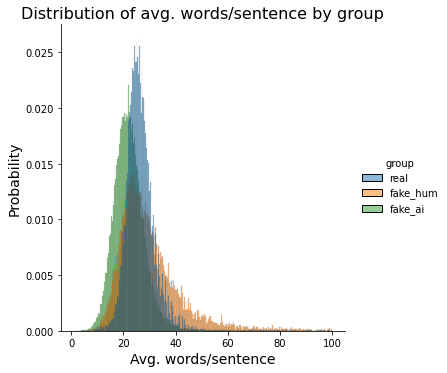

In [ ]:
# Plotting probability distribution due to uneven # of samples between groups
sns.displot(articles_df, x='words_per_sent', hue='group', stat='probability', common_norm=False)

plt.ylabel("Probability", fontsize= 14)
plt.xlabel("Avg. words/sentence", fontsize= 14)
plt.title("Distribution of avg. words/sentence by group", fontsize=16)

In [ ]:
# Create column of lowercase text
articles_df['text_lower'] = articles_df['text'].apply(lambda x: x.lower())

articles_df.head()

,text,group,length,sentences,words_per_sent,text_lower
0,The head of a conservative Republican faction ...,real,4636,[The head of a conservative Republican faction...,24.700000,the head of a conservative republican faction ...
1,Transgender people will be allowed for the fir...,real,4054,[Transgender people will be allowed for the fi...,29.190476,transgender people will be allowed for the fir...
2,The special counsel investigation of links bet...,real,2766,[The special counsel investigation of links be...,26.882353,the special counsel investigation of links bet...
3,Trump campaign adviser George Papadopoulos tol...,real,2431,[Trump campaign adviser George Papadopoulos to...,23.312500,trump campaign adviser george papadopoulos tol...
4,President Donald Trump called on the U.S. Post...,real,5173,"[President Donald Trump called on the U.S., Po...",20.850000,president donald trump called on the u.s. post...


In [ ]:
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

stopwords = set(stopwords.words('english')) 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We create a function that tokenizes text into words and removes stop words. 

In [ ]:
def tokenize_text(article):
  """ take a text string and
  - tokenizes words
  - lowers case
  - removes stopwords
  - remove non alpha tokens

  :param article_list: list of strings
  :return: list of cleaned text
  """

  tok_text = nltk.word_tokenize(article)
  tok_text = [word.lower() for word in tok_text]
  tok_text = [word for word in tok_text if word not in stopwords]
  tok_text = [word for word in tok_text if word.isalpha()]
  

  return tok_text

In [ ]:
# Create a list of text articles for each group
real_text_list = list(articles_df.text[articles_df.group == "real"]) 
fakehum_text_list= list(articles_df.text[articles_df.group == "fake_hum"])
ai_text_list = list(articles_df.text[articles_df.group == "fake_ai"])


# Tokenize and clean the lists from stopwords
# each result is list of lists containing words for each article
real_word_list = [tokenize_text(article) for article in real_text_list] 
fakehum_word_list = [tokenize_text(article) for article in fakehum_text_list] 
ai_word_list = [tokenize_text(article) for article in ai_text_list] 


#flatten the list of lists into a single list of words
flat_real_word_list = [word for article in real_word_list for word in article]
flat_fakehum_word_list = [word for article in fakehum_word_list for word in article]
flat_ai_word_list = [word for article in ai_word_list for word in article]

In [ ]:
from collections import Counter

# 50 most common words for real
real_cnt = Counter(flat_real_word_list)
real_most_common = real_cnt.most_common(50)

# Show top 30
real_most_common[:30]

[('said', 94947),
 ('trump', 52120),
 ('would', 30469),
 ('president', 25176),
 ('state', 18991),
 ('government', 17660),
 ('states', 15913),
 ('house', 15730),
 ('also', 15396),
 ('new', 15353),
 ('republican', 14780),
 ('united', 14775),
 ('people', 14528),
 ('told', 13637),
 ('could', 13229),
 ('last', 12240),
 ('one', 12148),
 ('party', 12059),
 ('two', 11185),
 ('election', 11148),
 ('year', 10624),
 ('campaign', 10233),
 ('former', 10122),
 ('donald', 9994),
 ('security', 9688),
 ('percent', 9679),
 ('north', 9384),
 ('clinton', 9222),
 ('court', 9085),
 ('white', 8902)]

In [ ]:
# 50 most common words for fake_hum
fakehum_cnt = Counter(flat_fakehum_word_list)
fakehum_most_common = fakehum_cnt.most_common(50)

# Show top 30
fakehum_most_common[:30]

[('trump', 62411),
 ('said', 22051),
 ('people', 19781),
 ('president', 18432),
 ('would', 17100),
 ('one', 16460),
 ('donald', 14556),
 ('like', 13330),
 ('obama', 12119),
 ('clinton', 11765),
 ('even', 10476),
 ('also', 10359),
 ('via', 9960),
 ('white', 9553),
 ('new', 9473),
 ('time', 9345),
 ('news', 9162),
 ('image', 9010),
 ('hillary', 8974),
 ('us', 8223),
 ('get', 8178),
 ('state', 8132),
 ('campaign', 7978),
 ('know', 7959),
 ('going', 7667),
 ('house', 7617),
 ('republican', 7511),
 ('america', 7181),
 ('could', 7172),
 ('first', 6933)]

In [ ]:
# 50 most common words for ai
ai_cnt = Counter(flat_ai_word_list)
ai_most_common = ai_cnt.most_common(50)

# Show top 30
ai_most_common[:30]

[('said', 322637),
 ('new', 207829),
 ('also', 173136),
 ('one', 165536),
 ('would', 164123),
 ('people', 159626),
 ('first', 111802),
 ('time', 110423),
 ('get', 100370),
 ('like', 98788),
 ('make', 95227),
 ('could', 90304),
 ('two', 88930),
 ('government', 84623),
 ('us', 81396),
 ('year', 76372),
 ('last', 73249),
 ('state', 73188),
 ('police', 72901),
 ('going', 70961),
 ('game', 69158),
 ('use', 68580),
 ('trump', 68485),
 ('may', 67738),
 ('many', 66074),
 ('way', 65811),
 ('years', 65482),
 ('see', 65451),
 ('world', 65355),
 ('want', 64943)]

In [ ]:
from wordcloud import WordCloud

In [ ]:
real_words = []
for i in range(len(real_most_common)):
  # Add the word, not the frequency count
  real_words.append(real_most_common[i][0])

# List of most 50 common words in real
real_words



fake_words = []
for i in range(len(fakehum_most_common)):
  # Add the word, not the frequency count
  fake_words.append(fakehum_most_common[i][0])

# List of most 50 common words in fake
fake_words

['trump',
 'said',
 'people',
 'president',
 'would',
 'one',
 'donald',
 'like',
 'obama',
 'clinton',
 'even',
 'also',
 'via',
 'white',
 'new',
 'time',
 'news',
 'image',
 'hillary',
 'us',
 'get',
 'state',
 'campaign',
 'know',
 'going',
 'house',
 'republican',
 'america',
 'could',
 'first',
 'make',
 'right',
 'many',
 'states',
 'american',
 'media',
 'say',
 'think',
 'made',
 'country',
 'way',
 'republicans',
 'told',
 'video',
 'back',
 'election',
 'women',
 'years',
 'two',
 'want']

In [ ]:
# Create set from the 50 most common words from both human-authored groups
human_words = set(real_words + fake_words)

print(len(human_words))
print("")
print(human_words)

77

{'donald', 'republican', 'time', 'military', 'state', 'people', 'president', 'including', 'even', 'white', 'minister', 'administration', 'campaign', 'say', 'want', 'house', 'like', 'get', 'could', 'year', 'security', 'new', 'obama', 'first', 'since', 'also', 'image', 'right', 'way', 'presidential', 'china', 'video', 'hillary', 'court', 'democratic', 'officials', 'week', 'united', 'trump', 'law', 'tax', 'via', 'america', 'last', 'party', 'us', 'country', 'told', 'two', 'make', 'back', 'government', 'media', 'national', 'percent', 'former', 'know', 'north', 'one', 'tuesday', 'american', 'think', 'women', 'years', 'news', 'states', 'going', 'many', 'would', 'senate', 'made', 'election', 'wednesday', 'said', 'foreign', 'republicans', 'clinton'}


In [ ]:
# Tag most common human-authored words with parts of speech
nltk.pos_tag(human_words)

[('donald', 'JJ'),
 ('republican', 'JJ'),
 ('time', 'NN'),
 ('military', 'JJ'),
 ('state', 'NN'),
 ('people', 'NNS'),
 ('president', 'NN'),
 ('including', 'VBG'),
 ('even', 'RB'),
 ('white', 'JJ'),
 ('minister', 'NN'),
 ('administration', 'NN'),
 ('campaign', 'NN'),
 ('say', 'VBP'),
 ('want', 'VBP'),
 ('house', 'NN'),
 ('like', 'IN'),
 ('get', 'NN'),
 ('could', 'MD'),
 ('year', 'NN'),
 ('security', 'NN'),
 ('new', 'JJ'),
 ('obama', 'NN'),
 ('first', 'RB'),
 ('since', 'IN'),
 ('also', 'RB'),
 ('image', 'NN'),
 ('right', 'JJ'),
 ('way', 'NN'),
 ('presidential', 'JJ'),
 ('china', 'NN'),
 ('video', 'NN'),
 ('hillary', 'JJ'),
 ('court', 'NN'),
 ('democratic', 'JJ'),
 ('officials', 'NNS'),
 ('week', 'NN'),
 ('united', 'JJ'),
 ('trump', 'NN'),
 ('law', 'NN'),
 ('tax', 'NN'),
 ('via', 'IN'),
 ('america', 'NN'),
 ('last', 'JJ'),
 ('party', 'NN'),
 ('us', 'PRP'),
 ('country', 'NN'),
 ('told', 'VBD'),
 ('two', 'CD'),
 ('make', 'VBP'),
 ('back', 'JJ'),
 ('government', 'NN'),
 ('media', 'NNS'),
 ('

By keeping nouns ONLY, we get a useful list of news-worthy words

In [ ]:
# keep only nouns in human_words
tagged_human_words = nltk.pos_tag(human_words)

human_nouns = [word_tag_pair[0] for word_tag_pair in tagged_human_words if word_tag_pair[1] == 'NN']
human_nouns 

['time',
 'state',
 'president',
 'minister',
 'administration',
 'campaign',
 'house',
 'get',
 'year',
 'security',
 'obama',
 'image',
 'way',
 'china',
 'video',
 'court',
 'week',
 'trump',
 'law',
 'tax',
 'america',
 'party',
 'country',
 'government',
 'percent',
 'news',
 'election',
 'wednesday']

In [ ]:
# Remove the following words: way, image, time, year, video, get, week
human_nouns = [word for word in human_nouns if word not in ['way', 'time', 'image', 'year', 'video', 'get', 'week']]

# Final list
human_nouns

['state',
 'president',
 'minister',
 'administration',
 'campaign',
 'house',
 'security',
 'obama',
 'china',
 'court',
 'trump',
 'law',
 'tax',
 'america',
 'party',
 'country',
 'government',
 'percent',
 'news',
 'election',
 'wednesday']

In [ ]:
def contains_word_in_list(text, word_list):
  """ Given a text string, returns true if string contains any word in word_list
  else returns false

  :param - text -- string
  : word_list - a list of words
  """
  if any(word in text for word in word_list):
    return True
  else:
    return False

In [ ]:
# Create column
articles_df["contains_human_word"] = articles_df['text_lower'].apply(lambda x: contains_word_in_list(x, human_nouns))

In [ ]:
# Lets recount how many articles we have before dropping more AI articles

print("# of articles for real: " + str(len(articles_df[articles_df['group'] == 'real'])))
print("# of articles for fake_hum: " + str(len(articles_df[articles_df['group'] == 'fake_hum'])))
print("# of articles for fake_ai: " + str(len(articles_df[articles_df['group'] == 'fake_ai'])))

# of articles for real: 20034
# of articles for fake_hum: 16307
# of articles for fake_ai: 164697


In [ ]:
# Drop AI_articles without human news words
articles_df.drop(articles_df[(articles_df.group=="fake_ai") & (articles_df.contains_human_word==False)].index, inplace=True)

# Drop contains_human_word column because no longer needed
articles_df.drop(['contains_human_word'], axis=1, inplace=True)

# Reset index
articles_df.reset_index(drop=True, inplace=True)

print("# of articles for real: " + str(len(articles_df[articles_df['group'] == 'real'])))
print("# of articles for fake_hum: " + str(len(articles_df[articles_df['group'] == 'fake_hum'])))
print("# of articles for fake_ai: " + str(len(articles_df[articles_df['group'] == 'fake_ai'])))

# of articles for real: 20034
# of articles for fake_hum: 16307
# of articles for fake_ai: 116775


In [ ]:
# AI most common words before drop
ai_most_common[:15]

[('said', 322637),
 ('new', 207829),
 ('also', 173136),
 ('one', 165536),
 ('would', 164123),
 ('people', 159626),
 ('first', 111802),
 ('time', 110423),
 ('get', 100370),
 ('like', 98788),
 ('make', 95227),
 ('could', 90304),
 ('two', 88930),
 ('government', 84623),
 ('us', 81396)]

In [ ]:
# AI most common words after drop
new_ai_most_common = new_ai_cnt.most_common(50)
new_ai_most_common[:15]

[('said', 292242),
 ('new', 154735),
 ('also', 134873),
 ('would', 134161),
 ('people', 130194),
 ('one', 117196),
 ('government', 84623),
 ('first', 78657),
 ('time', 77888),
 ('state', 73188),
 ('could', 69682),
 ('trump', 68485),
 ('two', 67585),
 ('get', 66173),
 ('us', 65994)]

In [ ]:
# Final df
articles_df.head()

,text,group,length,sentences,words_per_sent,text_lower,sentiment
0,The head of a conservative Republican faction ...,real,4636,[The head of a conservative Republican faction...,24.700000,the head of a conservative republican faction ...,6.0
1,Transgender people will be allowed for the fir...,real,4054,[Transgender people will be allowed for the fi...,29.190476,transgender people will be allowed for the fir...,3.0
2,The special counsel investigation of links bet...,real,2766,[The special counsel investigation of links be...,26.882353,the special counsel investigation of links bet...,-9.0
3,Trump campaign adviser George Papadopoulos tol...,real,2431,[Trump campaign adviser George Papadopoulos to...,23.312500,trump campaign adviser george papadopoulos tol...,-15.0
4,President Donald Trump called on the U.S. Post...,real,5173,"[President Donald Trump called on the U.S., Po...",20.850000,president donald trump called on the u.s. post...,-15.0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

real_text = articles_df[articles_df['group'] == "real"][['text','group']][:1000]
fake_text = articles_df[articles_df['group']=='fake_hum'][['text','group']][:500]
ai_text = articles_df[articles_df['group']=='fake_ai'][['text','group']][:500]

# Clustering
clustering_text_X = real_text['text'].append(fake_text['text']).append(ai_text['text'])

# Classification - Real vs. AI
# X = real_ai_text_X | y = real_ai_text_y
real_ai_text_X = real_text['text'][:500].append(ai_text['text'])
real_ai_text_y_raw = real_text['group'][:500].append(ai_text['group'])
real_ai_text_y = []
for val in real_ai_text_y_raw:
  if val == 'real':
    real_ai_text_y.append(0)
  else:
    real_ai_text_y.append(1)

# Classification - Real vs. Human
# X = real_human_text_X | y = real_human_text_y
real_human_text_X = real_text['text'][:500].append(fake_text['text'])
real_human_text_y_raw = real_text['group'][:500].append(fake_text['group'])
real_human_text_y = []
for val in real_human_text_y_raw:
  if val == 'real':
    real_human_text_y.append(0)
  else:
    real_human_text_y.append(1)

# Classification - Real vs. All Fake
# X = real_allfake_text_X | y = real_allfake_text_y
real_allfake_text_X = real_text['text'].append(fake_text['text']).append(ai_text['text'])
real_allfake_text_y_raw = real_text['group'].append(fake_text['group']).append(ai_text['group'])
real_allfake_text_y = []
real_allfake_text_clusters = []
for val in real_allfake_text_y_raw:
  if val == 'real':
    real_allfake_text_clusters.append(1)
    real_allfake_text_y.append(0)   
  elif val == 'fake_hum':
    real_allfake_text_clusters.append(2)
    real_allfake_text_y.append(1)
  else:
    real_allfake_text_clusters.append(0)
    real_allfake_text_y.append(1)


In [ ]:
tf_idf_vectorizor = TfidfVectorizer()
tf_idf = tf_idf_vectorizor.fit_transform(real_ai_text_X)
tf_idf_norm = normalize(tf_idf)
X_real_ai = tf_idf_norm.toarray()

tf_idf_vectorizor2 = TfidfVectorizer()
tf_idf2 = tf_idf_vectorizor2.fit_transform(real_human_text_X)
tf_idf_norm2 = normalize(tf_idf2)
X_real_human = tf_idf_norm2.toarray()

tf_idf_vectorizor3 = TfidfVectorizer()
tf_idf3 = tf_idf_vectorizor3.fit_transform(real_allfake_text_X)
tf_idf_norm3 = normalize(tf_idf3)
X_real_allfake = tf_idf_norm3.toarray()

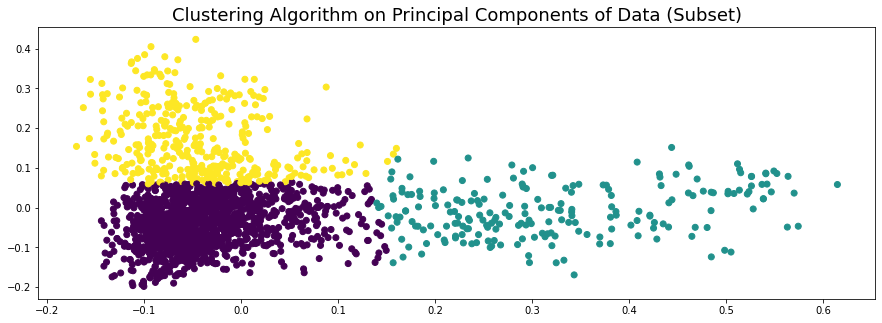

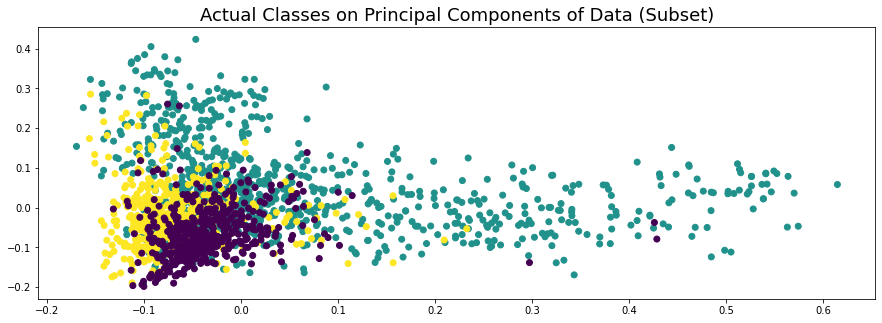

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(X_real_allfake)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

clustering_df = pd.DataFrame(Y_sklearn)
clustering_df.columns = ['x', 'y']
clustering_df['prediction'] = prediction

plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1], c = prediction);
plt.title("Clustering Algorithm on Principal Components of Data (Subset)", size = 18)
plt.gcf().set_size_inches(15,5)

plt.figure()
plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1], c = real_allfake_text_clusters);
plt.title("Actual Classes on Principal Components of Data (Subset)", size = 18)
plt.gcf().set_size_inches(15,5)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

# Limiting to 16,000 to control for different samples sizes between groups
real_text = articles_df[articles_df['group'] == "real"][['sentences','group']][:16000]
fake_text = articles_df[articles_df['group']=='fake_hum'][['sentences','group']][:16000]
ai_text = articles_df[articles_df['group']=='fake_ai'][['sentences','group']][:16000]

# Clustering
clustering_text_X = real_text['sentences'].append(fake_text['sentences']).append(ai_text['sentences'])

# Classification - Real vs. AI
# X = real_ai_text_X | y = real_ai_text_y
real_ai_text_X = real_text['sentences'].append(ai_text['sentences'])
real_ai_text_y_raw = real_text['group'].append(ai_text['group'])
real_ai_text_y = []
for val in real_ai_text_y_raw:
  if val == 'real':
    real_ai_text_y.append(0)
  else:
    real_ai_text_y.append(1)

# Classification - Real vs. Human
# X = real_human_text_X | y = real_human_text_y
real_human_text_X = real_text['sentences'].append(fake_text['sentences'])
real_human_text_y_raw = real_text['group'].append(fake_text['group'])
real_human_text_y = []
for val in real_human_text_y_raw:
  if val == 'real':
    real_human_text_y.append(0)
  else:
    real_human_text_y.append(1)

# Classification - Real vs. All Fake
# X = real_allfake_text_X | y = real_allfake_text_y
real_allfake_text_X = real_text['sentences'].append(fake_text['sentences'][:8000]).append(ai_text['sentences'][:10000])
real_allfake_text_y_raw = real_text['group'].append(fake_text['group'][:8000]).append(ai_text['group'][:10000])
real_allfake_text_y = []
real_allfake_text_clusters = []
for val in real_allfake_text_y_raw:
  if val == 'real':
    real_allfake_text_clusters.append(2)
    real_allfake_text_y.append(0)   
  elif val == 'fake_hum':
    real_allfake_text_clusters.append(0)
    real_allfake_text_y.append(1)
  else:
    real_allfake_text_clusters.append(1)
    real_allfake_text_y.append(1)


In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc

real_ai_text_X_raw = Dictionary(real_ai_text_X)
real_allfake_text_X_raw = Dictionary(real_allfake_text_X)
real_human_text_X_raw = Dictionary(real_human_text_X)

real_ai_corpus = [real_ai_text_X_raw.doc2bow(line) for line in real_ai_text_X]
real_allfake_corpus = [real_allfake_text_X_raw.doc2bow(line) for line in real_allfake_text_X]
real_human_corpus = [real_human_text_X_raw.doc2bow(line) for line in real_human_text_X]

real_ai_model = TfidfModel(real_ai_corpus)
real_allfake_model = TfidfModel(real_allfake_corpus)
real_human_model = TfidfModel(real_human_corpus)

real_ai_vector = real_ai_model[real_ai_corpus]
real_allfake_vector = real_allfake_model[real_allfake_corpus]
real_human_vector = real_human_model[real_human_corpus]

real_ai_X = corpus2csc(real_ai_vector).T
real_allfake_X = corpus2csc(real_allfake_vector).T
real_human_X = corpus2csc(real_human_vector).T



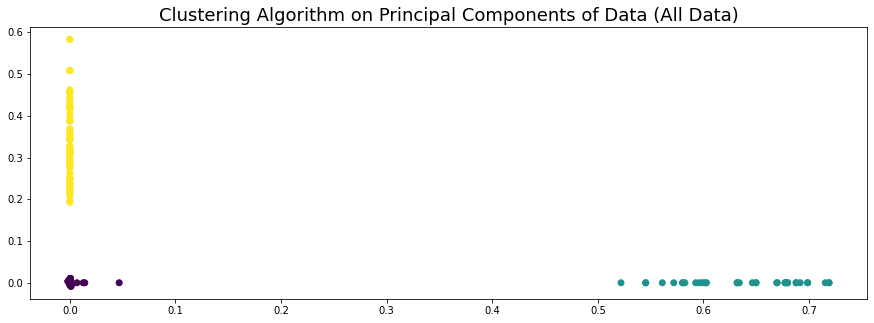

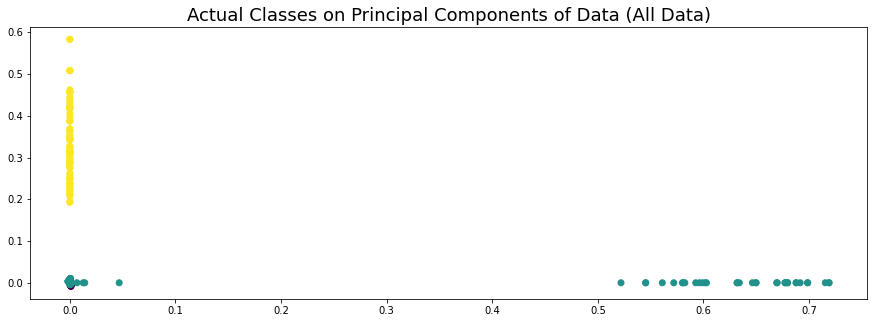

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

sklearn_pca = TruncatedSVD(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(real_allfake_X)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

clustering_df = pd.DataFrame(Y_sklearn)
clustering_df.columns = ['x', 'y']
clustering_df['prediction'] = prediction


plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1], c = prediction);
plt.title("Clustering Algorithm on Principal Components of Data (All Data)", size = 18)
plt.gcf().set_size_inches(15,5)

plt.figure()
plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1], c = real_allfake_text_clusters);
plt.title("Actual Classes on Principal Components of Data (All Data)", size = 18)
plt.gcf().set_size_inches(15,5)

plt.show()

**Logistic Regression (1) - Real News vs. AI News**





In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = real_ai_X
y = real_ai_text_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression()
logit = lr.fit(X_train,y_train)
y_predict = logit.predict(X_test)


print("Accuracy: ", logit.score(X, y)*100,"%")

Accuracy:  92.09375 %


**SVM (1) - Real News vs. AI News**

In [ ]:
from sklearn.svm import SVC

X = real_ai_X
y = real_ai_text_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svc = SVC()
svm = svc.fit(X_train,y_train)
y_predict = svm.predict(X_test)

print("Accuracy: ", svm.score(X, y)*100,"%")

Accuracy:  90.48125 %
